In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind,wilcoxon,ranksums
import cmasher as cmr

In [2]:
with open("pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl", "rb") as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df["pid"].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df["pid"].isin(subj_list)]

from sklearn.cluster import KMeans
from munkres import Munkres
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
M = 20
num_resamples = 500

In [4]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [5]:
def reference_comms(num_states, X):
    return np.mean(np.stack(X,axis=0),axis=0)

def align_two_partitions(source_comms, target_comms):
    # align source onto target

    # distatnce matrix
    Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(Dd)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi


def align_partitions(num_states, X_resample, X_origsample):
    comm_cntrs = reference_comms(num_states, X_resample)
    best_pis = []
    for idx, comms in tqdm(enumerate(X_origsample)):
        _, best_pi = align_two_partitions(source_comms=comms, target_comms=comm_cntrs)
        best_pis.append(best_pi)
    return best_pis


def get_attractors(type,model=None,idx_sample=None):
    # if idx_resample<=100:
    #     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_sample}.pkl','rb') as f:
    #         model,_,_,_ = pickle.load(f)
    # elif idx_resample>100:
    if type=='resample':
        # with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_sample}.pkl','rb') as f:
        #     model,_,_,_ = pickle.load(f)
        pass
    elif type=='origsample':
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_origsample{idx_sample}.pkl','rb') as f:
            model,_,_,_ = pickle.load(f)
    
    As = model.dynamics.As
    bs = model.dynamics.bs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]
    attractors = np.zeros((K, N))
    for k in range(K):
        attractors[k, :] = C @ (np.linalg.inv(np.eye(D) - As[k]) @ bs[k]) + d
    attractors /= np.expand_dims(np.linalg.norm(attractors, axis=1), axis=1)
    return attractors.T

all_attractors_resamples = []
for idx_resample in tqdm(range(1, 1 + num_resamples)):
    all_attractors_resamples.append(get_attractors(type='resample', model=all_models[idx_resample]))

all_attractors_origsamples = []
for idx_sample in tqdm(range(1, 1 + 10)):
    all_attractors_origsamples.append(get_attractors(type='origsample', idx_sample=idx_sample))

all_perms = align_partitions(K, all_attractors_resamples, all_attractors_origsamples)

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]
10it [00:00, 2477.88it/s]


In [6]:
all_perms

[(0, 1, 2, 3, 5, 4),
 (0, 1, 2, 3, 5, 4),
 (5, 1, 2, 3, 4, 0),
 (0, 1, 2, 3, 4, 5),
 (5, 1, 2, 3, 4, 0),
 (0, 1, 3, 5, 4, 2),
 (0, 1, 2, 3, 4, 5),
 (0, 4, 2, 3, 5, 1),
 (0, 1, 2, 3, 5, 4),
 (0, 1, 2, 3, 5, 4)]

In [7]:
def get_df(idx_resample, perm):
    # if idx_resample<=100:
    #     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
    #         model, q, elbos, resampled_subj_list = pickle.load(f)
    # elif idx_resample>100:
    #     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
    #         model, q, elbos, resampled_subj_list = pickle.load(f)    
    with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_origsample{idx_resample}.pkl','rb') as f:
        model, q, elbos, resampled_subj_list = pickle.load(f)    
        
    model.permute(perm)
    # model.permute(np.array([0, 1, 3, 2, 4, 5]))
    # model.permute(np.array([1,2,4,3,5,0])) #300 resamples
    # model.permute(np.array([2,4,3,0,1,5])) #400 resamples
    # model.permute(np.array([1,0,2,3,4,5])) #500 resamples
    # model.permute(np.array([1,0,4,2,3,5])) #200 resamples input5
    # model.permute(np.array([2,3,0,4,5,1])) #200 resamples input15

    resampled_df = []
    for pid in resampled_subj_list:
        resampled_df.append(orig_df[orig_df["pid"] == pid])
    resampled_df = pd.concat(resampled_df).reset_index().drop("index", axis=1)
    df = resampled_df

    df["continuous_states"] = [None] * df.shape[0]
    df["discrete_states"] = [None] * df.shape[0]
    hrflag = 0
    prox_bins = list(np.arange(M // 2) / (M // 2))[1:]
    dir_bins = [0]
    nprox = len(prox_bins) + 1
    ndir = len(dir_bins) + 1
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]["proximity"]
        prox = prox - prox.min()
        prox = prox / prox.max()
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1 - np.digitize(df.loc[idx_row]["direction"], bins=dir_bins)
        stim_category = (nprox * ndir - 1) * dird + ((-1) ** dird) * proxd
        input = np.roll(np.eye(nprox * ndir)[stim_category], shift=hrflag, axis=0)

        y = df.loc[idx_row]["timeseries"]
        x = q.mean_continuous_states[idx_row]
        z = model.most_likely_states(x, y, input=input)
        df.at[idx_row, "continuous_states"] = x
        df.at[idx_row, "discrete_states"] = z
        prox = df.loc[idx_row]["proximity"]
        prox = prox - prox.min()
        prox = prox / prox.max()
        df.at[idx_row, "proximity"] = prox

    return df,model

In [8]:
all_dfs_orig = {}
all_models_orig = {}
for idx_resample in tqdm(range(1,11)):
    all_dfs_orig[idx_resample],all_models_orig[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


In [9]:
prox_bins = list(np.arange(M // 2) / (M // 2))[1:]
dir_bins = [0]
nprox = len(prox_bins) + 1
ndir = len(dir_bins) + 1
hrf_shift = 3


def get_p_state_giv_stimulus(df, shuffle_z: bool = False):

    zs = []
    stims = []
    for idx_row in range(df.shape[0]):
        z = np.copy(df.loc[idx_row]["discrete_states"])  # sequence of discrete states

        # if shuffle_z is True: np.random.shuffle(z)
        if shuffle_z:
            z = np.roll(z, shift=np.random.randint(z.shape[0]))

        # bin proximity and direction values
        prox = np.digitize(df.loc[idx_row]["proximity"], bins=prox_bins)
        dir = 1 - np.digitize(df.loc[idx_row]["direction"], bins=dir_bins)

        # take care of hrf lag
        if hrf_shift > 0:
            prox = np.roll(prox, shift=hrf_shift)[hrf_shift:]
            dir = np.roll(dir, shift=hrf_shift)[hrf_shift:]
            z = z[hrf_shift:]

        # make sure lengths are consistent
        assert len(z) == len(prox)
        assert len(z) == len(dir)

        stim = (nprox * ndir - 1) * dir + ((-1) ** dir) * prox
        stims.append(stim)
        zs.append(z)

    zs = np.hstack(zs)
    stims = np.hstack(stims)

    # calculate marginals
    prob_mat = np.zeros((K, nprox * ndir))
    for idx_state in range(K):
        for idx_stim in range(nprox * ndir):
            prob_mat[idx_state, idx_stim] = np.sum(
                (zs == idx_state) * (stims == idx_stim)
            ) / np.sum(stims == idx_stim)
    # prob_mat = prob_mat / prob_mat.sum()

    return prob_mat

def get_p_state(df):
    zs = np.hstack(list(df['discrete_states'].values))
    p_state = np.zeros(K)
    for k in range(K):
        p_state[k] = (zs==k).sum()/zs.shape[0]
    return p_state

In [10]:
true_count_mat_all = []
null_count_mats_all = []
for idx_resample in tqdm(range(1, 11)):

    true_count_mat_all.append(get_p_state_giv_stimulus(all_dfs_orig[idx_resample], shuffle_z=False))
    
    null_count_mats = []
    for _ in tqdm(range(100)):
        null_count_mats.append(get_p_state_giv_stimulus(all_dfs_orig[idx_resample], shuffle_z=True))
    null_count_mats = np.stack(null_count_mats)         
    null_count_mats_all.append(null_count_mats)

100%|██████████| 10/10 [06:03<00:00, 36.34s/it]


In [11]:
xticklabels = [None] * nprox * ndir
dir = "AR"
for i in [0, 1]:
    for j, prox in enumerate(prox_bins + [1]):
        xticklabels[(nprox * ndir - 1) * i + ((-1) ** i) * j] = f"${dir[i]}_"+"{"+f"{j+1}"+"}$"

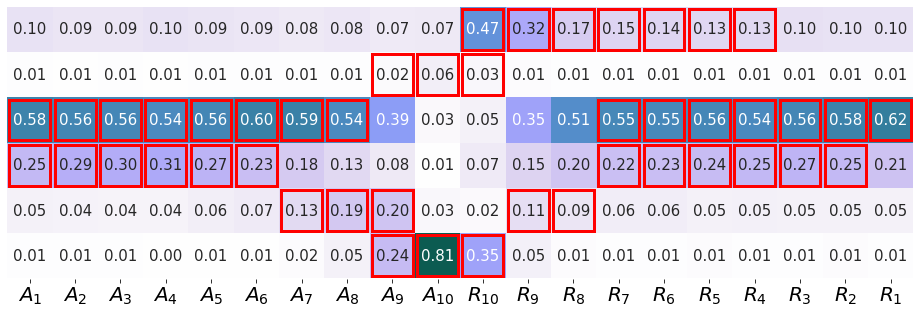

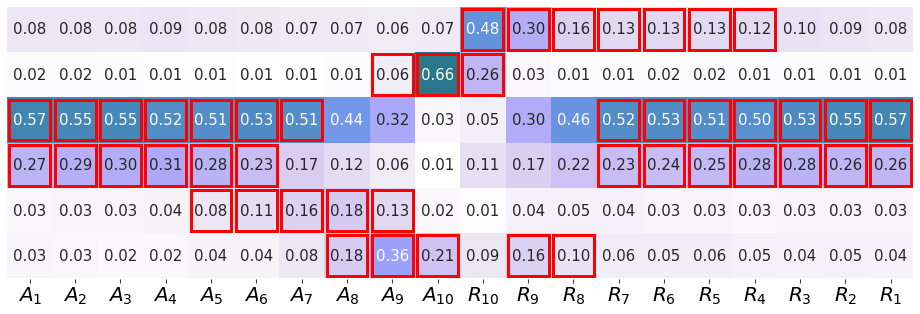

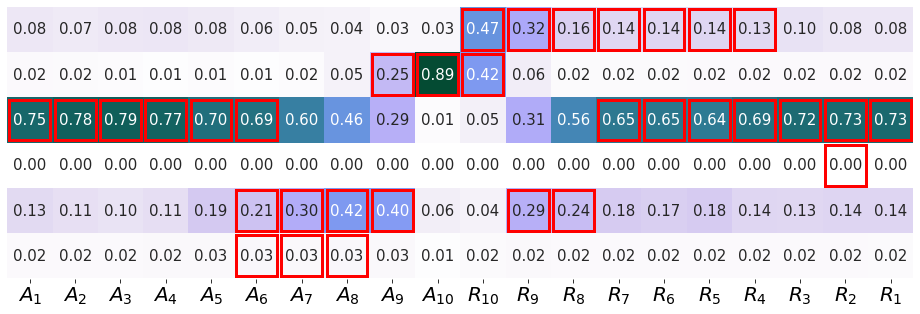

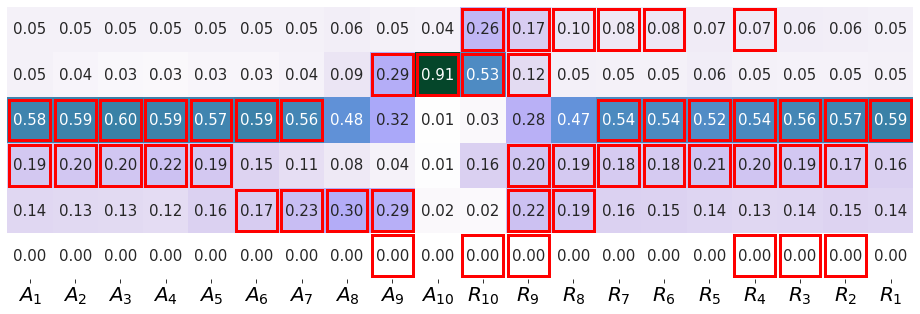

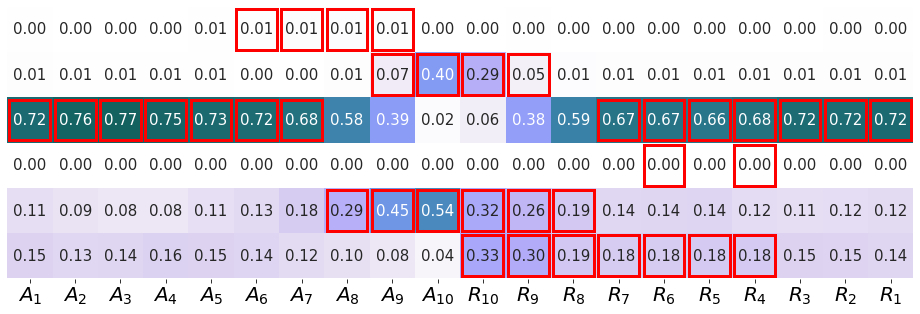

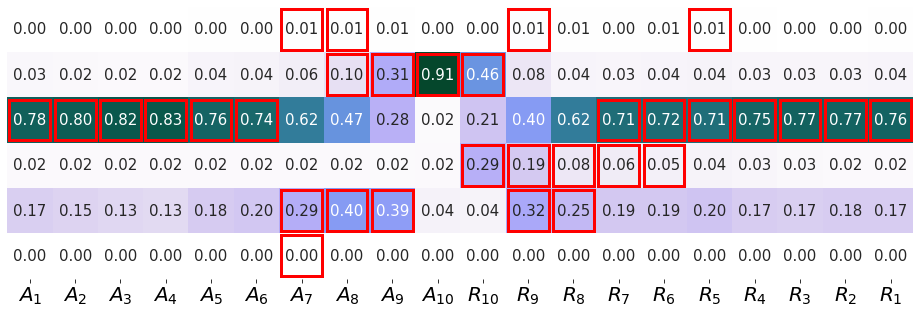

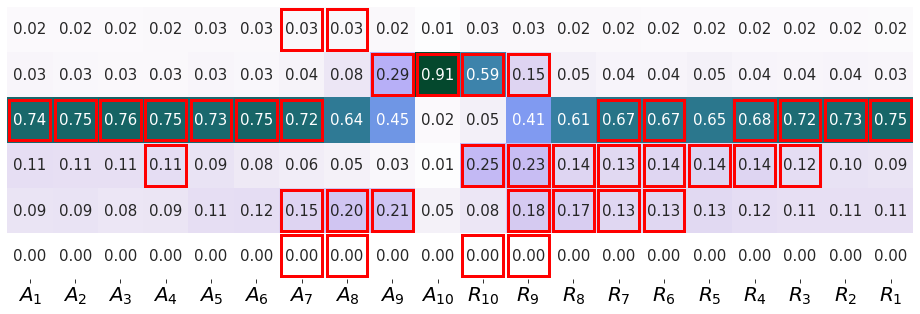

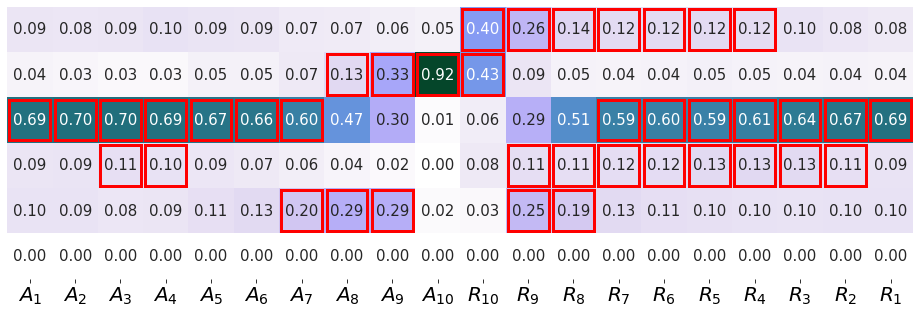

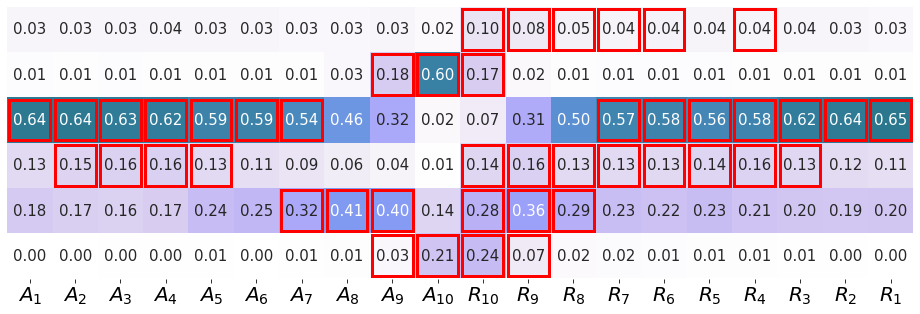

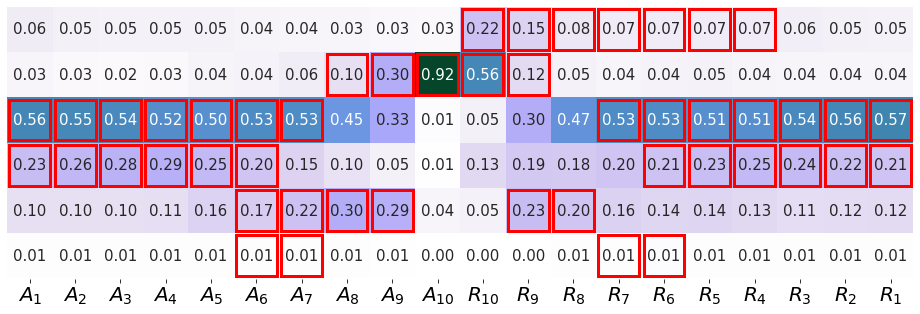

In [12]:
for idx_resample in range(10):
    true_count_mat = true_count_mat_all[idx_resample]
    null_count_mats = null_count_mats_all[idx_resample]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,5), sharex=True)
    sns.heatmap(
        true_count_mat,
        annot=true_count_mat,
        fmt=".2f",
        annot_kws={"size": 15},
        cmap=cmr.horizon_r,  # "gist_earth",
        vmin=0,
        vmax=1,
        ax=ax,
        cbar=False,
        square=True,
    )
    _ = ax.set_yticks([])
    _ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)

    for i in range(true_count_mat.shape[0]):
        for j in range(true_count_mat.shape[1]):
            true_val = true_count_mat[i,j]
            null_vals = null_count_mats[:,i,j]
            # null_vals = null_vals[~np.isnan(null_vals)]
            # pvalue = np.sum(null_vals>true_val)/len(null_vals)
            pvalue = ranksums(
                true_val,
                null_vals,
                # equal_var=False,
                alternative="greater",
            ).pvalue
            if pvalue < 0.05:# / (nprox * ndir * K):
                ax.add_patch(
                    patches.Rectangle(
                        (j + 0.05, i + 0.05),
                        width=0.9,
                        height=0.9,
                        linewidth=3,
                        edgecolor="red",
                        facecolor="none",
                    )
                )